# MetronIA

## Beat Spectrum & DTW

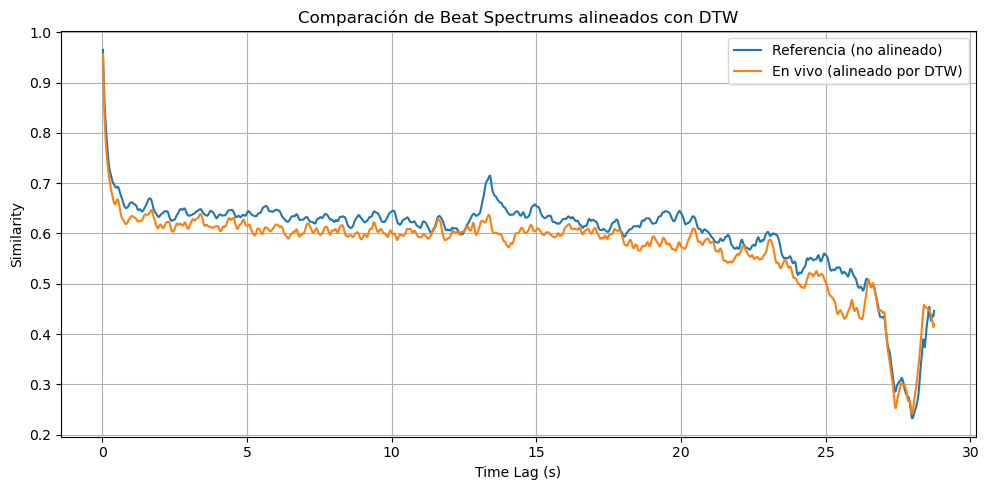

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.spatial.distance import cdist

# === Parámetros ===
hop_length = 512
n_mfcc = 20

reference_path = 'audio/veneciana-reference.mp3'
live_path = 'audio/veneciana-live.mp3'

reference_audio, sampling_rate = librosa.load(reference_path)
live_audio, sampling_rate = librosa.load(live_path)

# === Funciones ===
def extract_features(audio, sr, hop_length=512, n_mfcc=20):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc)
    return librosa.util.normalize(mfcc, axis=1).T  # (frames, features)

def compute_self_similarity_matrix(features):
    D = cdist(features, features, metric='cosine')
    S = 1 - D
    return S

def compute_beat_spectrum(S):
    n = S.shape[0]
    return np.array([np.mean(np.diag(S, k=lag)) for lag in range(1, n)])

# === Cargar características ===
ref_feat = extract_features(reference_audio, sampling_rate, hop_length)
live_feat = extract_features(live_audio, sampling_rate, hop_length)

# === DTW para alinear ===
D, wp = librosa.sequence.dtw(X=ref_feat.T, Y=live_feat.T, metric='cosine')
wp = np.array(wp[::-1])  # Asegura que va de principio a fin

# === Aplicar alineamiento a live_feat ===
aligned_live_feat = np.zeros_like(ref_feat)
for i, (ref_idx, live_idx) in enumerate(wp):
    if ref_idx < len(aligned_live_feat) and live_idx < len(live_feat):
        aligned_live_feat[ref_idx] = live_feat[live_idx]

# === Calcular matrices de autosemejanza ===
S_ref = compute_self_similarity_matrix(ref_feat)
S_aligned = compute_self_similarity_matrix(aligned_live_feat)

# === Beat spectrums ===
beat_ref = compute_beat_spectrum(S_ref)
beat_aligned = compute_beat_spectrum(S_aligned)

# === Visualización comparativa ===
times = np.arange(1, len(beat_ref) + 1) * hop_length / sampling_rate

plt.figure(figsize=(10, 5))
plt.plot(times, beat_ref, label='Referencia (no alineado)')
plt.plot(times, beat_aligned, label='En vivo (alineado por DTW)')
plt.xlabel("Time Lag (s)")
plt.ylabel("Similarity")
plt.title("Comparación de Beat Spectrums alineados con DTW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Comparación 1 ChatGPT

## Comparación directa de beat spectrums

In [2]:
def compare_beat_spectrums(beat_ref, beat_aligned, threshold=0.2):
    diff = np.abs(beat_ref - beat_aligned)
    if np.max(diff) > threshold:
        print("⚠️ Diferencias significativas en el beat spectrum.")
    else:
        print("✅ Beat spectrum similar.")
    return diff

## Detección de onsets y comparación

In [8]:
def compare_onsets(audio_ref, audio_live, sr, margin=0.05):
    onsets_ref = librosa.onset.onset_detect(y=audio_ref, sr=sr, units='time')
    onsets_live = librosa.onset.onset_detect(y=audio_live, sr=sr, units='time')

    matched = []
    unmatched_ref = []
    unmatched_live = list(onsets_live)  # convertir a lista para poder usar .remove()

    for onset in onsets_ref:
        diffs = np.abs(np.array(unmatched_live) - onset)
        if len(diffs) > 0 and np.min(diffs) < margin:
            idx = np.argmin(diffs)
            matched.append((onset, unmatched_live[idx]))
            unmatched_live.pop(idx)  # eliminar el onset emparejado
        else:
            unmatched_ref.append(onset)

    print(f"✅ Onsets emparejados: {len(matched)}")
    print(f"❌ Notas faltantes (en vivo): {len(unmatched_ref)}")
    print(f"❌ Notas extras (en vivo): {len(unmatched_live)}")

    return matched, unmatched_ref, unmatched_live


## Comparar tempo local

In [10]:
def compare_local_tempo(audio_ref, audio_live, sr, threshold=5):
    tempo_ref, _ = librosa.beat.beat_track(y=audio_ref, sr=sr)
    tempo_live, _ = librosa.beat.beat_track(y=audio_live, sr=sr)

    tempo_ref = float(tempo_ref)
    tempo_live = float(tempo_live)

    print(f"🎼 Tempo referencia: {tempo_ref:.2f} BPM")
    print(f"🎼 Tempo en vivo: {tempo_live:.2f} BPM")

    if abs(tempo_ref - tempo_live) > threshold:
        print("⚠️ Diferencia significativa de tempo.")
    else:
        print("✅ Tempo similar.")


## Evaluar irregularidad en el DTW path

In [5]:
def evaluate_dtw_path(wp, tolerance=0.3):
    wp = np.array(wp)
    ref_idxs, live_idxs = wp[:, 0], wp[:, 1]
    deltas = live_idxs - ref_idxs
    deviations = np.abs(deltas - np.mean(deltas))

    if np.max(deviations) > tolerance * len(ref_idxs):
        print("⚠️ Camino DTW con desviaciones anómalas.")
    else:
        print("✅ Camino DTW razonablemente regular.")

    return deviations


## Segmentación por compases y validación

In [6]:
def segment_and_validate(audio_ref, audio_live, sr, compas_dur=2.0, tolerance=0.2):
    duration_ref = librosa.get_duration(y=audio_ref, sr=sr)
    duration_live = librosa.get_duration(y=audio_live, sr=sr)

    n_compases_ref = int(duration_ref // compas_dur)
    n_compases_live = int(duration_live // compas_dur)

    print(f"🎵 Compases en referencia: {n_compases_ref}")
    print(f"🎵 Compases en vivo: {n_compases_live}")

    if abs(n_compases_ref - n_compases_live) > 1:
        print("⚠️ Desajuste en el número de compases.")
    elif abs(duration_ref - duration_live) > tolerance * duration_ref:
        print("⚠️ Diferencias en la duración de los compases.")
    else:
        print("✅ Estructura de compases compatible.")


In [13]:
# Llamadas a las funciones de evaluación
compare_beat_spectrums(beat_ref, beat_aligned)
compare_onsets(reference_audio, live_audio, sampling_rate)
compare_local_tempo(reference_audio, live_audio, sampling_rate)
evaluate_dtw_path(wp)
segment_and_validate(reference_audio, live_audio, sampling_rate, compas_dur=2.0)


✅ Beat spectrum similar.
✅ Onsets emparejados: 52
❌ Notas faltantes (en vivo): 71
❌ Notas extras (en vivo): 54
🎼 Tempo referencia: 112.35 BPM
🎼 Tempo en vivo: 107.67 BPM
✅ Tempo similar.
✅ Camino DTW razonablemente regular.
🎵 Compases en referencia: 14
🎵 Compases en vivo: 15
✅ Estructura de compases compatible.


C:\Users\sarag\AppData\Local\Temp\ipykernel_35640\2997437160.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tempo_ref = float(tempo_ref)
C:\Users\sarag\AppData\Local\Temp\ipykernel_35640\2997437160.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tempo_live = float(tempo_live)


# Comparación 2 ChatGPT

## Detectar errores nota por nota
Lo básico es comparar los onsets (ataques de notas) detectados en el audio de referencia y en el audio en vivo, con un margen temporal para considerar que dos onsets "coinciden".

Onsets emparejados → correctos

Onsets en referencia sin pareja → notas faltantes (no tocadas)

Onsets en vivo sin pareja → notas extras (tocadas donde no debería)

## Código para detectar y clasificar onsets

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import librosa

def compare_onsets(audio_ref, audio_live, sr, margin=0.05):
    onsets_ref = librosa.onset.onset_detect(y=audio_ref, sr=sr, units='time')
    onsets_live = librosa.onset.onset_detect(y=audio_live, sr=sr, units='time')

    matched = []
    unmatched_ref = []
    unmatched_live = list(onsets_live)

    for onset in onsets_ref:
        diffs = np.abs(np.array(unmatched_live) - onset)
        if len(diffs) > 0 and np.min(diffs) < margin:
            idx = np.argmin(diffs)
            matched.append((onset, unmatched_live[idx]))
            unmatched_live.pop(idx)
        else:
            unmatched_ref.append(onset)

    print(f"✅ Onsets emparejados: {len(matched)}")
    print(f"❌ Notas faltantes (en vivo): {len(unmatched_ref)}")
    print(f"❌ Notas extras (en vivo): {len(unmatched_live)}")

    return onsets_ref, onsets_live, matched, unmatched_ref, unmatched_live


## Visualización de onsets y errores
Para entender mejor dónde están esos errores, vamos a plotear en una línea de tiempo los onsets:

En azul los onsets de referencia

En verde los onsets emparejados (correctos)

En rojo los onsets extras (en vivo pero no en referencia)

En negro los onsets faltantes (en referencia pero no en vivo)

In [15]:
def plot_onsets_errors(onsets_ref, onsets_live, matched, unmatched_ref, unmatched_live):
    plt.figure(figsize=(12, 3))

    # Onsets referencia (azul)
    plt.vlines(onsets_ref, 0.8, 1.0, color='blue', label='Onsets referencia')

    # Onsets emparejados (verde)
    matched_live = [live for _, live in matched]
    plt.vlines(matched_live, 0.6, 0.8, color='green', label='Onsets emparejados')

    # Onsets faltantes (negro)
    plt.vlines(unmatched_ref, 0.4, 0.6, color='black', label='Notas faltantes')

    # Onsets extras (rojo)
    plt.vlines(unmatched_live, 0.2, 0.4, color='red', label='Notas extras')

    plt.ylim(0, 1.1)
    plt.yticks([])
    plt.xlabel('Tiempo (segundos)')
    plt.title('Detección de errores rítmicos nota por nota')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


✅ Onsets emparejados: 52
❌ Notas faltantes (en vivo): 71
❌ Notas extras (en vivo): 54


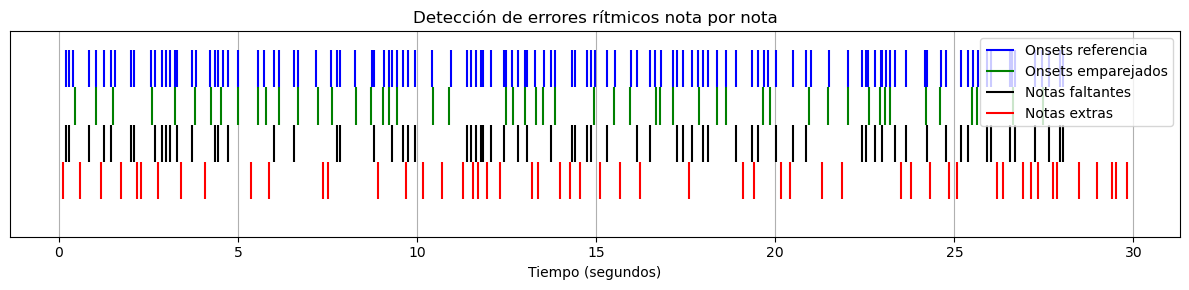

In [16]:
onsets_ref, onsets_live, matched, unmatched_ref, unmatched_live = compare_onsets(reference_audio, live_audio, sampling_rate)
plot_onsets_errors(onsets_ref, onsets_live, matched, unmatched_ref, unmatched_live)


## Clasificación ampliada de errores nota por nota
Vamos a definir 4 categorías para los onsets que se emparejan pero tienen desplazamiento temporal:

Onset correcto: diferencia ≤ margin (ej. 50 ms)

Onset adelantado: versión en vivo toca antes que referencia por más de margin

Onset atrasado: versión en vivo toca después que referencia por más de margin

Notas extras y faltantes: como antes (sin pareja)

In [17]:
def compare_onsets_detailed(audio_ref, audio_live, sr, margin=0.05):
    onsets_ref = librosa.onset.onset_detect(y=audio_ref, sr=sr, units='time')
    onsets_live = librosa.onset.onset_detect(y=audio_live, sr=sr, units='time')

    matched_correct = []
    matched_early = []
    matched_late = []
    unmatched_ref = []
    unmatched_live = list(onsets_live)

    for onset in onsets_ref:
        if len(unmatched_live) == 0:
            unmatched_ref.append(onset)
            continue

        diffs = np.array(unmatched_live) - onset
        abs_diffs = np.abs(diffs)
        min_idx = np.argmin(abs_diffs)
        min_diff = diffs[min_idx]

        if abs_diffs[min_idx] <= margin:
            matched_correct.append((onset, unmatched_live[min_idx]))
            unmatched_live.pop(min_idx)
        else:
            # Si hay desvío pero está cerca, se clasifica adelantado o atrasado
            if min_diff < -margin:
                # live onset antes que referencia
                matched_early.append((onset, unmatched_live[min_idx]))
                unmatched_live.pop(min_idx)
            elif min_diff > margin:
                # live onset después que referencia
                matched_late.append((onset, unmatched_live[min_idx]))
                unmatched_live.pop(min_idx)
            else:
                unmatched_ref.append(onset)

    # Lo que queda en unmatched_live es notas extras sin pareja
    # Lo que quedó sin emparejar en referencia son notas faltantes

    print(f"✅ Onsets correctos: {len(matched_correct)}")
    print(f"⚠️ Onsets adelantados: {len(matched_early)}")
    print(f"⚠️ Onsets atrasados: {len(matched_late)}")
    print(f"❌ Notas faltantes (en vivo): {len(unmatched_ref)}")
    print(f"❌ Notas extras (en vivo): {len(unmatched_live)}")

    return (onsets_ref, onsets_live,
            matched_correct, matched_early, matched_late,
            unmatched_ref, unmatched_live)


In [18]:
def plot_onsets_detailed(onsets_ref, onsets_live,
                         matched_correct, matched_early, matched_late,
                         unmatched_ref, unmatched_live):
    plt.figure(figsize=(14, 3))

    plt.vlines(onsets_ref, 0.8, 1.0, color='blue', label='Onsets referencia')
    plt.vlines([live for _, live in matched_correct], 0.6, 0.8, color='green', label='Onsets correctos')
    plt.vlines([live for _, live in matched_early], 0.4, 0.6, color='orange', label='Onsets adelantados')
    plt.vlines([live for _, live in matched_late], 0.2, 0.4, color='purple', label='Onsets atrasados')
    plt.vlines(unmatched_ref, 0.0, 0.2, color='black', label='Notas faltantes')
    plt.vlines(unmatched_live, -0.2, 0.0, color='red', label='Notas extras')

    plt.ylim(-0.3, 1.1)
    plt.yticks([])
    plt.xlabel('Tiempo (segundos)')
    plt.title('Errores de ejecución nota por nota: adelantados, atrasados, extras y faltantes')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [19]:
def detect_rhythm_pattern_errors(onsets_ref, onsets_live, threshold=0.1):
    # Intervalos entre onsets (duraciones de notas o silencios)
    intervals_ref = np.diff(onsets_ref)
    intervals_live = np.diff(onsets_live)

    # Variación entre intervalos consecutivos (segundos)
    variation_ref = np.abs(np.diff(intervals_ref))
    variation_live = np.abs(np.diff(intervals_live))

    # Detectar repeticiones (onsets muy cercanos en vivo)
    repeats_live = np.where(np.diff(onsets_live) < 0.1)[0]

    # Detectar huecos grandes en vivo (intervalos > promedio+threshold)
    avg_interval_ref = np.mean(intervals_ref)
    large_gaps_live = np.where(intervals_live > avg_interval_ref + threshold)[0]

    print(f"Repeticiones detectadas en vivo (intervalos < 100 ms): {len(repeats_live)}")
    print(f"Huecos grandes detectados en vivo (> promedio + {threshold}s): {len(large_gaps_live)}")

    return repeats_live, large_gaps_live


✅ Onsets correctos: 0
⚠️ Onsets adelantados: 1
⚠️ Onsets atrasados: 105
❌ Notas faltantes (en vivo): 17
❌ Notas extras (en vivo): 0


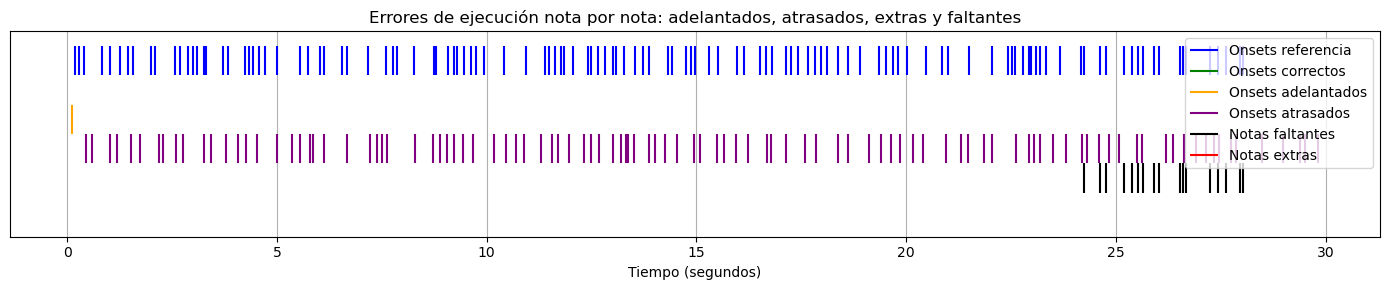

Repeticiones detectadas en vivo (intervalos < 100 ms): 3
Huecos grandes detectados en vivo (> promedio + 0.1s): 31


In [20]:
onsets_ref, onsets_live, matched_correct, matched_early, matched_late, unmatched_ref, unmatched_live = compare_onsets_detailed(reference_audio, live_audio, sampling_rate)

plot_onsets_detailed(onsets_ref, onsets_live, matched_correct, matched_early, matched_late, unmatched_ref, unmatched_live)

repeats_live, large_gaps_live = detect_rhythm_pattern_errors(onsets_ref, onsets_live)


In [22]:
from IPython.display import Audio


In [23]:
# Listen to reference (blue)
print("Reference recording:")
Audio(data=reference_audio, rate=sampling_rate)

Reference recording:


In [24]:
# Listen to reference (orange)
print("Live recording:")
Audio(data=live_audio, rate=sampling_rate)

Live recording:
